# Practical work 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [107]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from matplotlib import cm
# Useful functions 
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale, kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussianKernel()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [12]:
def computeR(image,scale,kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    sobelY = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    sobelX = np.transpose(sobelY)
    
    Ix = scipy.signal.convolve2d(image,sobelX,mode='same')
    Iy = scipy.signal.convolve2d(image,sobelY,mode='same')
    
    Ixx = Ix**2
    Iyy = Iy**2
    Ixy = Ix*Iy
    
    gauss = gaussianKernel(scale)
    gaussX = scipy.signal.convolve2d(Ixx,gauss,mode='same')
    gaussY = scipy.signal.convolve2d(Iyy,gauss,mode='same')
    gaussProduct = scipy.signal.convolve2d(Ixy,gauss,mode='same')
    
    detM = gaussX*gaussY - gaussProduct*gaussProduct
    traceM = gaussX + gaussY
    
    R = detM - kappa*traceM**2
    
    return R           

2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

Text(0.5, 1.0, 'Harris response')

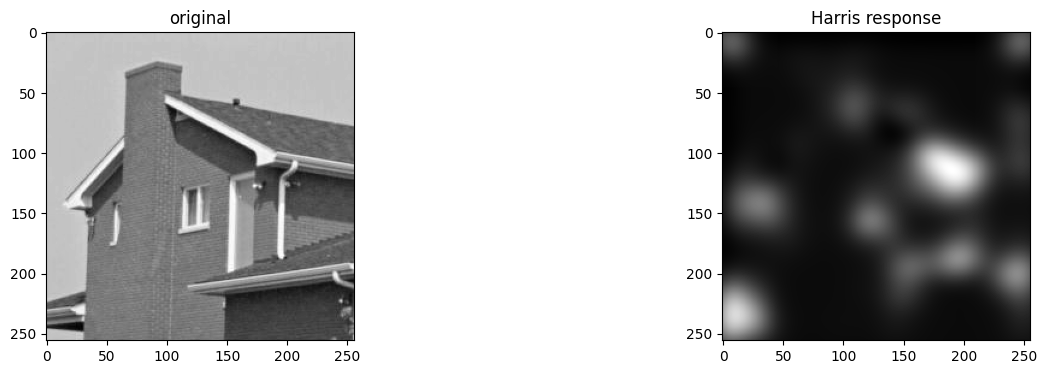

In [13]:
house = np.array(Image.open('img/house2.png'))

fig = plt.figure(figsize=plt.figaspect(0.25))
    
ax = fig.add_subplot(1, 2, 1)
ax.imshow(house,cmap="gray")
ax.set_title("original")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(computeR(house,15,0.04),cmap="gray")
ax.set_title("Harris response")



Text(0.5, 1.0, 'Harris response')

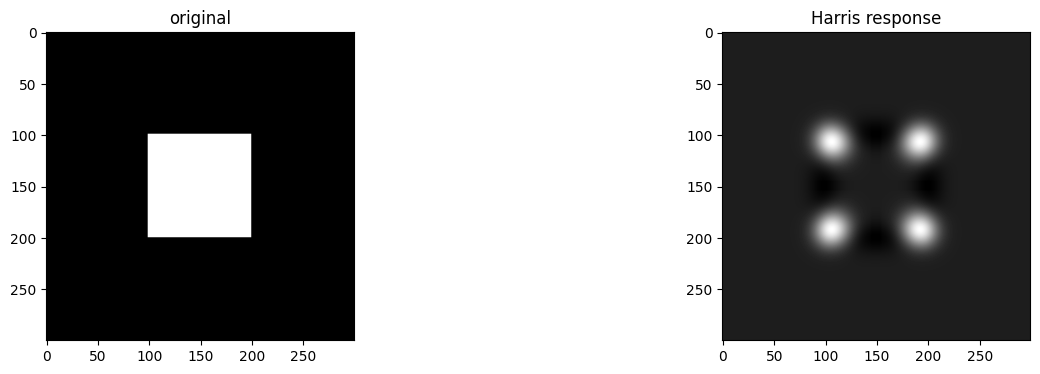

In [44]:
# un exemple plus simple

rect = np.array(Image.open('img/rectangle.png'))

fig = plt.figure(figsize=plt.figaspect(0.25))
    
ax = fig.add_subplot(1, 2, 1)
ax.imshow(rect,cmap="gray")
ax.set_title("original")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(computeR(rect,15,0.04),cmap="gray")
ax.set_title("Harris response")

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

Avec la seconde image (qui est très simple puisque ce n'est qu'un carré), on voit mieux ce que donne le détecteur de Harris. On obtient une image dans laquelle les coins apparaissent en blanc (valeurs positives), et les limites de surface apparaissent en noir (valeurs négatives). Tout ce qui n'est pas des coins ou des limites sont des zones (valent 0 dans la matrice) et apparaissent en gris

## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

In [27]:
def thresholdR(R, thres):
    """ Array[n, m] * float -> Array[n, m]
    """
    return np.where(R>thres,1,0)

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

In [28]:
def imagePad(I,h) :
    nb = int((max(h.shape[0],h.shape[1]) - 1) / 2.0)
    mat1 = np.hstack((np.zeros((I.shape[0], nb)), I, np.zeros((I.shape[0], nb))))
    mat2 = np.vstack((np.zeros((nb, mat1.shape[1])), mat1, np.zeros((nb, mat1.shape[1]))))
    return mat2

In [33]:
def rnms(R,Rbin) :
    
    R_tmp = imagePad(R,np.zeros((3,3)))
    Rbin_tmp = imagePad(Rbin,np.zeros((3,3)))
    Rlocmax = np.zeros(R_tmp.shape)
    
    for i in range(1,R.shape[0]) :
        for j in range(1,R.shape[1]) :
            neighbors = R_tmp[i-1:i+2,j-1:j+2]
            if (Rbin_tmp[i][j]==1 and R_tmp[i][j]==np.max(neighbors)) :
                Rlocmax[i][j] = 1
    
    return Rlocmax[1:Rlocmax.shape[0]-1,1:Rlocmax.shape[0]-1]

3) Write a function ``cornerDetector(image, scale, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

In [34]:
def cornerDetector(image, sigma, kappa, thres):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """    
    R = computeR(image,sigma,kappa)
    Rbin = thresholdR(R,thres)
    return rnms(R,Rbin)

4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

In [111]:
def visu_detected_edges(tmp_I, sigma, kappa, thres):
    I=tmp_I.copy()
    detector = cornerDetector(I, sigma, kappa, thres)

    fig = plt.figure(figsize=plt.figaspect(0.25))
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(tmp_I,cmap="gray")
    ax.set_title("original")

    new_I=np.dstack((tmp_I.copy(),tmp_I.copy(),tmp_I.copy()))


    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            if detector[i,j]>0:
                new_I[i-3:i+3,j-3:j+3]=[255,0,0]
                
                
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    X,Y = np.meshgrid(range(tmp_I.shape[1]), range(tmp_I.shape[0]))
    ax.plot_surface(X, Y, tmp_I, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    ax.set_title("3d projection of the original")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(new_I)
    ax.set_title("detected corners")
    
    
    fig = plt.figure(figsize=(1000//80,1000//80))




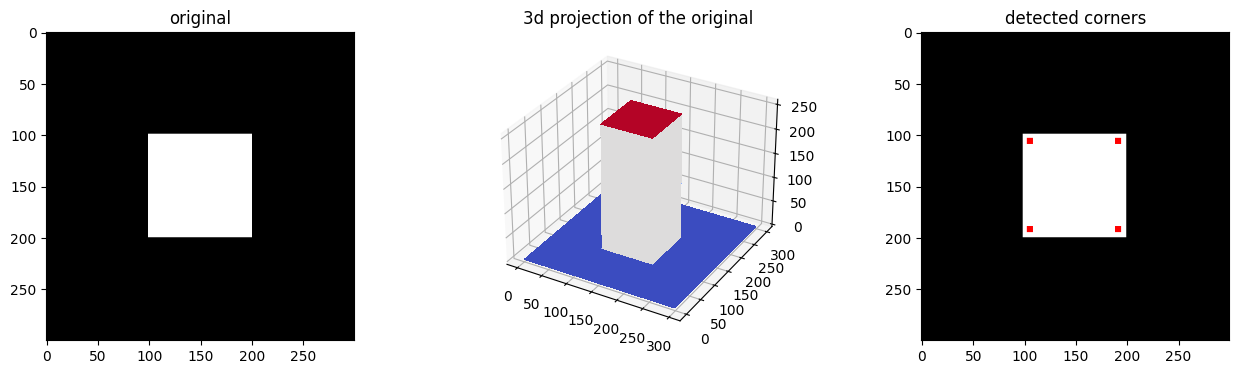

<Figure size 1200x1200 with 0 Axes>

In [112]:
visu_detected_edges(rect,15,0.04,0)

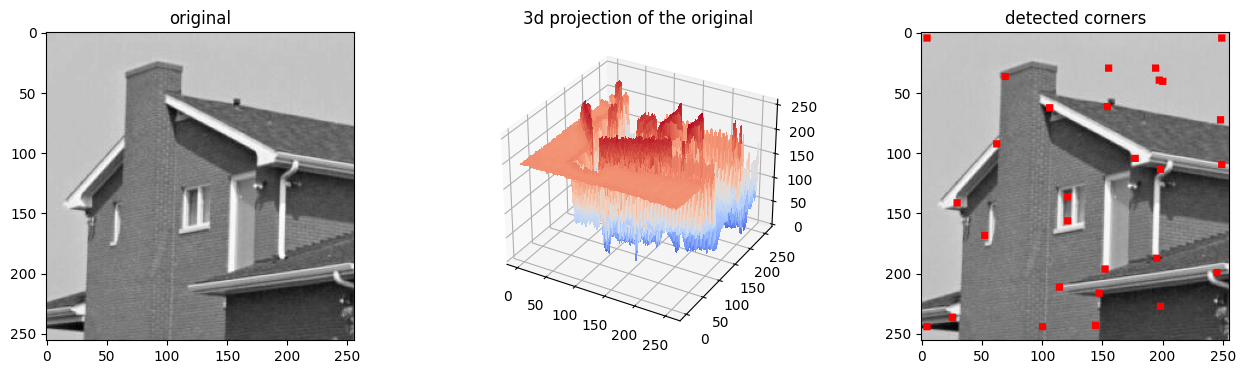

<Figure size 1200x1200 with 0 Axes>

In [118]:
visu_detected_edges(house,10,0.04,300)

5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

On peut voir qu'en fonction de la taille du noyau choisi, l'algo retourne plus ou moins de coins. En effet le filtre gaussien a tendance à retirer les basses fréquences qui caractérisent les contours et donc les coins, donc plus le filtre est grand et plus on retire de coins.

On remarque que l'algorithme a marqué plusieurs points dans le ciel comme des coins. Cela est dû au fait que le ciel n'est pas une texture d'une couleur unique (comme on peut le remarquer sur le plot 3D).



## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

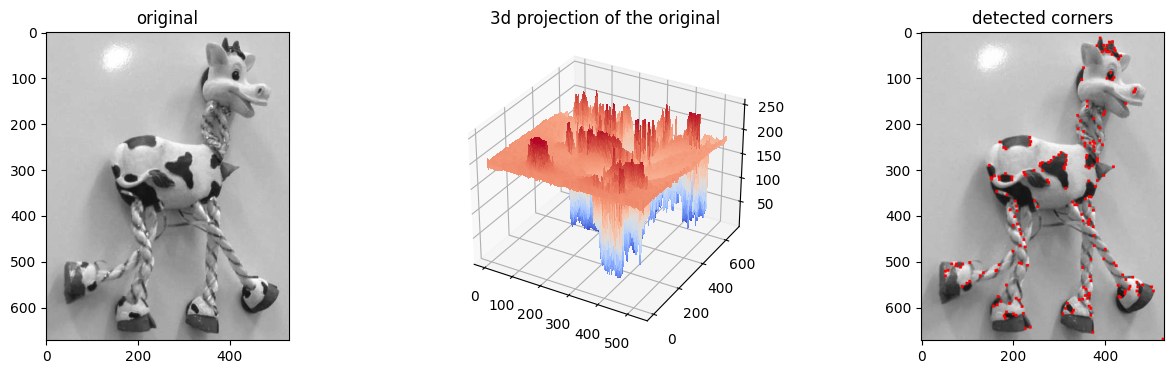

<Figure size 1200x1200 with 0 Axes>

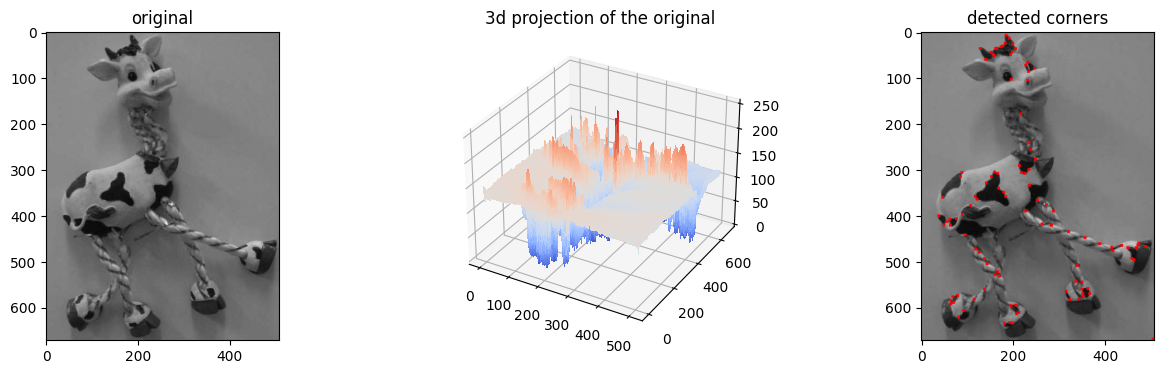

<Figure size 1200x1200 with 0 Axes>

In [136]:
toy1 = np.array(Image.open('img/toyHorse1.png'))
toy2 = np.array(Image.open('img/toyHorse2.png'))

visu_detected_edges(toy1,2.1,0.04,5e7)
visu_detected_edges(toy2,2.1,0.04,5e7)

2) What are the dynamic ranges of these two images ?

Your answer...

3) What are the transformations beetween the two images ?

Your answer...

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

Your Answer